In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ratings = pd.read_csv('ratings.csv')

# Convert explicit ratings to implicit feedback:
ratings['rating'] = 1.0
# Map userId and movieId:
user_ids = ratings['userId'].unique().tolist()
item_ids = ratings['movieId'].unique().tolist()
user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
item_to_idx = {iid: i for i, iid in enumerate(item_ids)}
ratings['user_idx'] = ratings['userId'].map(user_to_idx)
ratings['item_idx'] = ratings['movieId'].map(item_to_idx)
num_users = len(user_to_idx)
num_items = len(item_to_idx)
print(f"Number of users: {num_users}, items: {num_items}, interactions: {len(ratings)}")


Number of users: 610, items: 9724, interactions: 100836


In [5]:
# Sort by user and timestamp, then split
ratings_sorted = ratings.sort_values(['user_idx', 'timestamp'])
# Take the last interaction per user as test
test_df = ratings_sorted.groupby('user_idx').last().reset_index()
train_df = pd.merge(ratings_sorted, test_df[['user_idx','movieId']],
                    on=['user_idx','movieId'], how='left', indicator=True)
train_df = train_df[train_df['_merge'] == 'left_only']
train_df = train_df[['user_idx','item_idx','rating']]  # keep only needed columns
test_df = test_df[['user_idx','item_idx','rating']]


In [6]:
class NegSampleDataset(Dataset):
    def __init__(self, user_item_pairs, num_users, num_items, num_negatives=4):
        """
        user_item_pairs: list of user, item positive interactions
        num_users, num_items: total counts
        num_negatives: number of negatives per positive
        """
        self.num_users = num_users
        self.num_items = num_items
        self.user_item = user_item_pairs
        self.user_pos = {}
        for (u, i) in self.user_item:
            self.user_pos.setdefault(u, set()).add(i)
        self.neg_samples = []
        # Build samples list: (user, item, label)
        for (u, i) in self.user_item:
            # Positive sample
            self.neg_samples.append((u, i, 1))
            # Sample negatives
            for _ in range(num_negatives):
                neg_item = random.randrange(self.num_items)
                while neg_item in self.user_pos[u]:
                    neg_item = random.randrange(self.num_items)
                self.neg_samples.append((u, neg_item, 0))

    def __len__(self):
        return len(self.neg_samples)

    def __getitem__(self, idx):
        user, item, label = self.neg_samples[idx]
        return torch.tensor(user, dtype=torch.long), torch.tensor(item, dtype=torch.long), torch.tensor(label, dtype=torch.float)

# Prepare training samples list
train_pairs = list(zip(train_df['user_idx'], train_df['item_idx']))
train_dataset = NegSampleDataset(train_pairs, num_users, num_items, num_negatives=4)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)


In [7]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32, mlp_layers=[64,32]):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        # MLP layers for interaction
        layers = []
        input_dim = emb_dim*2
        for h in mlp_layers:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(mlp_layers[-1], 1)

    def forward(self, user, item):
        u = self.user_emb(user)
        v = self.item_emb(item)
        x = torch.cat([u, v], dim=1)
        x = self.mlp(x)
        x = self.output(x)
        return torch.sigmoid(x).squeeze()

# Instantiate NCF model
device = torch.device("cuda")
ncf_model = NCF(num_users, num_items, emb_dim=32, mlp_layers=[64,32]).to(device)


In [8]:
class DSSM(nn.Module):
    def __init__(self, num_users, num_items, emb_dim=32, hidden_dim=16):
        super(DSSM, self).__init__()
        # Embedding layers
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        # Additional hidden layers for each tower
        self.user_mlp = nn.Linear(emb_dim, hidden_dim)
        self.item_mlp = nn.Linear(emb_dim, hidden_dim)

    def forward(self, user, item):
        u = torch.relu(self.user_mlp(self.user_emb(user)))
        v = torch.relu(self.item_mlp(self.item_emb(item)))
        # Dot product of final vectors
        x = torch.sum(u * v, dim=1)
        return torch.sigmoid(x).squeeze()

dssm_model = DSSM(num_users, num_items, emb_dim=32, hidden_dim=16).to(device)


In [9]:
def train_model(model, train_loader, epochs=5, lr=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for (users, items, labels) in train_loader:
            users = users.to(device)
            items = items.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(users, items)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * users.size(0)
        avg_loss = epoch_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    print("Training done.\n")

# Train NCF
print("Training NCF model...")
train_model(ncf_model, train_loader, epochs=5, lr=0.001)
# Train DSSM
print("Training DSSM model...")
train_model(dssm_model, train_loader, epochs=5, lr=0.001)


Training NCF model...
Epoch 1/5, Loss: 0.4360
Epoch 2/5, Loss: 0.3400
Epoch 3/5, Loss: 0.3232
Epoch 4/5, Loss: 0.3165
Epoch 5/5, Loss: 0.3120
Training done.

Training DSSM model...
Epoch 1/5, Loss: 0.7009
Epoch 2/5, Loss: 0.6931
Epoch 3/5, Loss: 0.6927
Epoch 4/5, Loss: 0.6914
Epoch 5/5, Loss: 0.6898
Training done.



In [10]:
# Build train interaction sets for filtering
user_train_items = {}
for u, i in zip(train_df['user_idx'], train_df['item_idx']):
    user_train_items.setdefault(u, set()).add(i)

# Evaluation function
def evaluate_model(model, Ks=[5,10,20,50]):
    model.eval()
    recall = {K: [] for K in Ks}
    ndcg = {K: [] for K in Ks}
    with torch.no_grad():
        for idx, row in test_df.iterrows():
            u = int(row['user_idx'])
            true_item = int(row['item_idx'])
            # Score all items for this user
            users = torch.tensor([u]*num_items, dtype=torch.long).to(device)
            items = torch.arange(num_items, dtype=torch.long).to(device)
            scores = model(users, items).cpu().numpy()
            # Exclude items in training
            train_items = user_train_items.get(u, set())
            scores[list(train_items)] = -1  # set scores of seen items -1
            # Rank items by score
            ranked_items = np.argsort(-scores)
            for K in Ks:
                topK = ranked_items[:K]
                # Recall: 1 if true item in top K
                recall[K].append(1.0 if true_item in topK else 0.0)
                # NDCG: 1/log2(rank+2) if in topK, else 0
                if true_item in topK:
                    rank = int(np.where(topK == true_item)[0][0])
                    ndcg[K].append(1.0 / np.log2(rank+2))
                else:
                    ndcg[K].append(0.0)
    # average
    recall = {K: np.mean(recall[K]) for K in Ks}
    ndcg = {K: np.mean(ndcg[K]) for K in Ks}
    return recall, ndcg

Ks = [5, 10, 20, 50]
recall_ncf, ndcg_ncf = evaluate_model(ncf_model, Ks)
recall_dssm, ndcg_dssm = evaluate_model(dssm_model, Ks)
print("Recall@K (NCF):", recall_ncf)
print("NDCG@K  (NCF):", ndcg_ncf)
print("Recall@K (DSSM):", recall_dssm)
print("NDCG@K  (DSSM):", ndcg_dssm)


Recall@K (NCF): {5: np.float64(0.022950819672131147), 10: np.float64(0.040983606557377046), 20: np.float64(0.06229508196721312), 50: np.float64(0.11147540983606558)}
NDCG@K  (NCF): {5: np.float64(0.013609104271802173), 10: np.float64(0.01937571162352304), 20: np.float64(0.024692520541278937), 50: np.float64(0.03438138469522168)}
Recall@K (DSSM): {5: np.float64(0.013114754098360656), 10: np.float64(0.018032786885245903), 20: np.float64(0.03278688524590164), 50: np.float64(0.05573770491803279)}
NDCG@K  (DSSM): {5: np.float64(0.007249865457125476), 10: np.float64(0.008854136517386531), 20: np.float64(0.012639922816864156), 50: np.float64(0.017202062113604234)}


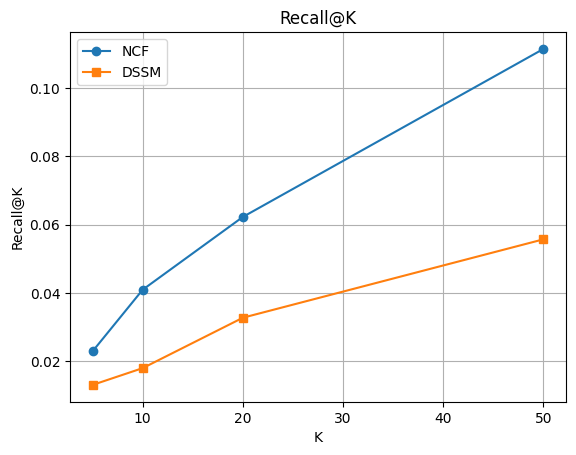

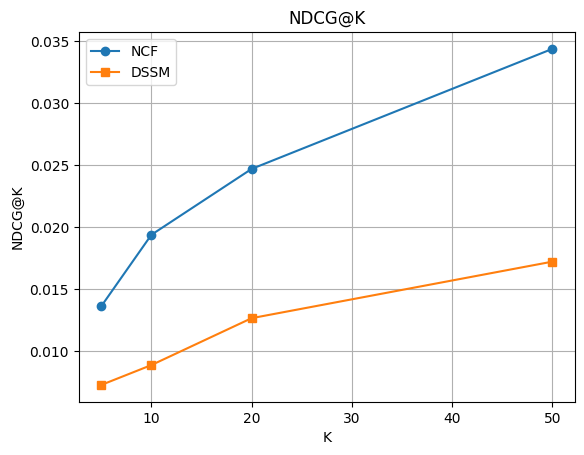

In [11]:
# Plot Recall@K
plt.figure()
plt.plot(Ks, [recall_ncf[K] for K in Ks], marker='o', label='NCF')
plt.plot(Ks, [recall_dssm[K] for K in Ks], marker='s', label='DSSM')
plt.title("Recall@K")
plt.xlabel("K")
plt.ylabel("Recall@K")
plt.legend()
plt.grid(True)

# Plot NDCG@K
plt.figure()
plt.plot(Ks, [ndcg_ncf[K] for K in Ks], marker='o', label='NCF')
plt.plot(Ks, [ndcg_dssm[K] for K in Ks], marker='s', label='DSSM')
plt.title("NDCG@K")
plt.xlabel("K")
plt.ylabel("NDCG@K")
plt.legend()
plt.grid(True)

plt.show()
